<class 'torch_geometric.loader.dataloader.DataLoader'>
Data(x=[144, 4], edge_index=[2, 20592]) found in data


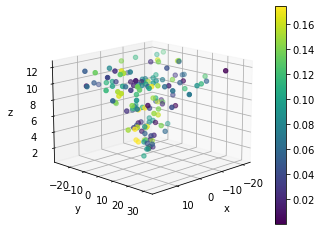

In [2]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

def build_edge_index(num_nodes):
    # Initialise the edge index matrix
    edge_matrix = torch.zeros((2, num_nodes*(num_nodes-1)), dtype=torch.long)
    
    # Populate the first row
    for node in range(num_nodes):
        for neighbour in range(num_nodes - 1):
            edge_matrix[0, node*(num_nodes-1)+neighbour] = node
    # Populate the second row
    neighbours = []
    for node in range(num_nodes):
        neighbours.append(list(np.arange(node)) + list(np.arange(node+1,num_nodes)))
    
    edge_matrix[1,:] = torch.tensor([item for sublist in neighbours for item in sublist])
    return edge_matrix
        
n_showers = 1000
nlayer = 12
max_energy = 1000
Event = []
max_hits = 368
hits_energy = torch.rand(n_showers)*max_energy
hits_energy_np = hits_energy.numpy()
for nEvent in range(n_showers):
    hit = []
    remaining_hits = max_hits
    for layer in range(nlayer):
        z = layer + 1
        nhits = torch.randint(low=1, high=z*5, size=(1,))
        energy_dep  = torch.rand((nhits[0],1))*(hits_energy_np[nEvent]/float(max_hits))
        position_xy = torch.randn((nhits[0],2))*z
        position_z  = torch.ones((nhits[0],1))*z
        position    = torch.cat([energy_dep,position_xy, position_z], axis=-1)
        hit.append(position)
        remaining_hits -= nhits
    all_hits = torch.cat(hit, axis=0)
    num_nodes = len(all_hits)
    edge_index = build_edge_index(num_nodes=num_nodes)
    data = Data(x=all_hits, edge_index=edge_index)
    Event.append(data)

    
if not os.path.exists('dataset'):
    os.system("mkdir -p dataset")
torch.save([Event,hits_energy], 'dataset/toy_model.pt')

dataset = torch.load("dataset/toy_model.pt")
loader = DataLoader(dataset)
print(type(loader))

np_list = []
nevent = 1
for key in dataset[0:nevent]:
    print(f'{key[0]} found in data')
    np_list.append((key[0].x.numpy()))
    points = np.concatenate(np_list)
    Energy = points[:,0]
    x      = points[:,1]
    y      = points[:,2]
    z      = points[:,3]
    w      = Energy

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
img = ax.scatter(x, y, z, c=w/5)
fig.colorbar(img)
ax.view_init(15,45)

Make some plots of key features of the simulated showers

newdataset:  Data(x=[144, 4], edge_index=[2, 20592])


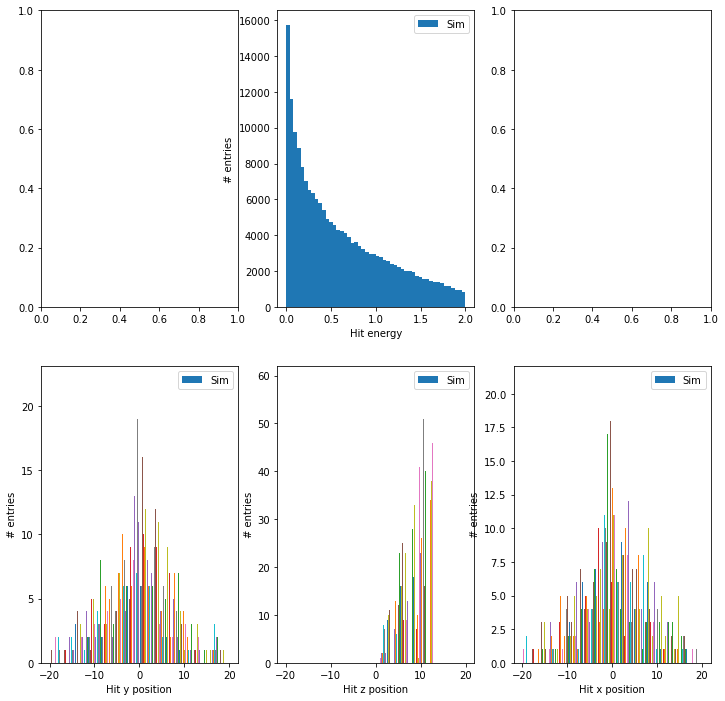

In [77]:
dataset = torch.load("dataset/toy_model.pt")
loader = DataLoader(dataset)

all_x = []
all_y = []
all_z = []
all_e = []
entries = []
inject_energy = []
newdataset = dataset[0]
np_list = []
print('newdataset: ', newdataset[0])
for key in newdataset[0:1000]:
    #print(f'{key} found in data')
    #np_list.append( (key[0].x.numpy()) )
    #points = np.concatenate(np_list)
    #print('points[:,0]: ', key.x.numpy()[:,0])
    all_e.append( key.x.numpy()[:,0] )
    all_x.append( key.x.numpy()[:,1] )
    all_y.append( key.x.numpy()[:,2] )
    all_z.append( key.x.numpy()[:,3])


fig, ax = plt.subplots(2,2, figsize=(12,12))
label = 'Sim'

'''ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, 200, range=(0,200), label=label)
ax[0][0].legend(loc='upper right')'''

ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy')
ax[0][1].hist(np.concatenate(all_e), 50, range=(0,2.0), label=label)
ax[0][1].legend(loc='upper right')

'''ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Injection energy')
ax[0][2].hist(inject_energy, 50, range=(0,200), label=label)
ax[0][2].legend(loc='upper right')'''

ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Hit x position')
ax[1][2].hist(np.concatenate(all_x), 50, range=(-20,20), label=label)
ax[1][2].legend(loc='upper right')

ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(np.concatenate(all_y), 50, range=(-20,20), label=label)
ax[1][0].legend(loc='upper right')

ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(np.concatenate(all_z), 50, range=(-20,20), label=label)
ax[1][1].legend(loc='upper right')
fig.show()

Running on device:  cuda
Cuda used to build pyTorch:  11.2
Current device:  0
Cuda arch list:  ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'compute_37']


  0%|          | 0/200 [00:00<?, ?it/s]

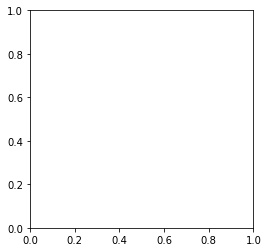

data: 1000
loading 1000 showers


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

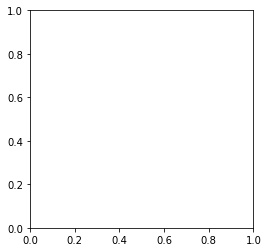

In [33]:
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATv2Conv, Linear
import tqdm
from IPython import display
%matplotlib inline
plt.gcf().canvas.draw()

class tdsm(nn.Module):
    def __init__(self,inputdim,embeddim,hiddendim,nhead):
        super().__init__()
        self.embed = nn.Linear(inputdim,embeddim)
        self.fcin = nn.Linear(embeddim*inputdim,hiddendim)
        self.fcout = nn.Linear(hiddendim,embeddim)
        self.out = nn.Linear(embeddim,inputdim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout()
        self.attn = nn.MultiheadAttention(embeddim, 8, batch_first=True)
        self.gat1 = GATv2Conv(embeddim, hiddendim, heads=nhead)
    def forward(self,data):
        x = data.x
        edge_idx = data.edge_index
        embedded_x = self.embed(x)
        residual_x = embedded_x.clone()
        torch_attn_out, torch_attn_out_weights = self.attn(embedded_x,embedded_x,embedded_x)
        attn_out = self.gat1(embedded_x, edge_idx)
        #print(f'torch_attn_out: {torch_attn_out.shape}')
        #print(f'attn_out: {attn_out.shape}')
        embedded_x = self.fcin(attn_out)
        embedded_x = self.act(embedded_x)
        embedded_x = self.dropout(embedded_x)
        embedded_x = self.fcout(embedded_x)
        embedded_x = embedded_x + residual_x
        score_output = self.out(embedded_x)
        #print(f'score_output: {score_output.shape}, {type(score_output)}')
        return score_output

def evaluate_model(model, in_showers, eps=1e-5):
    #print(f'Batch: {type(in_showers)} {in_showers}')
    #print(f'num graphs: {in_showers.num_graphs}')
    #print(f'batch vector: {in_showers.batch}')
    showers_in_batch = torch.max(in_showers.batch)
    in_x = in_showers.x
    random_t = torch.rand(1)*(1-eps) + eps
    z = torch.randn_like(in_x)
    perturbed_x = in_x + z
    model_output = model(in_showers)
    loss = (model_output+z)**2
    # sum over feature and node dimension
    sum_loss = torch.sum(loss, dim=(0,1))
    # If batch mode, the above dimensions need to change to be the last two dimensions
    # We then average over the batch here
    #mean_batch_loss = torch.mean(sum_loss)
    return sum_loss

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
global device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

n_epochs=200
batch_size=1
epoch_losses = []
tqdm_epoch = tqdm.notebook.trange(n_epochs)
fig, ax = plt.subplots(ncols=1, figsize=(4,4))
dh = display.display(fig, display_id=True)

data = dataset[0]
print(f'data: {len(data)}')
incident_e = dataset[1]
loader = DataLoader(dataset[0], batch_size=batch_size, shuffle=True)
print(f'loading {len(loader)} showers')
n_features = data[0].x.shape[1]
n_heads = 8
embed_dims = 512
hidden_dims = 256
model = tdsm(n_features, embed_dims, hidden_dims, n_heads)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
model.train()
for epoch in tqdm_epoch:
    cumulative_batch_loss = 0
    for batch in loader:
        batch.to(device)
        av_batch_loss = evaluate_model(model, batch)
        optimizer.zero_grad()
        av_batch_loss.backward()
        optimizer.step()
        cumulative_batch_loss+=av_batch_loss.item()
    epoch_loss = cumulative_batch_loss/len(loader)
    epoch_losses.append(epoch_loss)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(cumulative_batch_loss/batch_size))
    fig, ax = plt.subplots(ncols=1, figsize=(4,4))
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.plot(cumulative_batch_loss/batch_size, label='training')
    plt.legend(loc='upper right')
    plt.tight_layout()
    dh.update(fig)
    plt.close(fig)